In [58]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd

In [59]:
np.random.seed(0)
def get_surgery_time(mean,std):
    sh,sc = (mean/std)**2,std**2/mean
    return np.random.gamma(shape=sh,scale=sc)

In [60]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8*60 for i in range(32)]+[60*60 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 150
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)

{'CARD': 21, 'GASTRO': 27, 'GYN': 42, 'MED': 8, 'ORTHO': 26, 'URO': 26}
{'CARD': [0, 20], 'GASTRO': [21, 47], 'GYN': [48, 89], 'MED': [90, 97], 'ORTHO': [98, 123], 'URO': [124, 149]}


In [61]:
np.random.seed(0)
cib = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        #costs = sorted([np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)])
        costs = [np.random.randint(low=1,high=5)*110 for _ in range(len(blocks[s])-1)]
        f = 0
        for b in blocks[s][:len(blocks[s])-1]:
            cib[i,b-1] = costs[f]
            f += 1
            
        
dummy_cost = 800
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        b = blocks[s][-1]
        cib[i,b-1] = dummy_cost

cob = np.array([5.0 for _ in range(n_blocks)])
cgb = np.array([5.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])

In [62]:
#block and surgery of a speciality fesibility
p = [[0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1
        t += 1

In [63]:
n_scenarios = 10**3
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])

avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [64]:
opt = SolverFactory('cplex')
opt.options['timelimit'] = 3600
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\91824\AppData\Local\Temp\tmpm2qo4_mk.cplex.log' open.
CPLEX> New value for time limit in seconds: 3600
CPLEX> Problem 'C:\Users\91824\AppData\Local\Temp\tmp8th5reso.pyomo.lp' read.
Read time = 0.48 sec. (19.74 ticks)
CPLEX> Problem name         : C:\Users\91824\AppData\Local\Temp\tmp8th5reso.pyomo.lp
Objective sense      : Minimize
Variables            :   81701  [Nneg: 76001,  Binary: 5700]
Objective nonzeros   :   71035
Linear constraints   :   43851  [Less: 5700,  Equal: 38151]
  Nonzeros           : 1160401
  RHS nonzeros       :   39224

Variables            : Min LB: 0.000000   

   1269  1156    37162.3081   106    37354.7434    35505.1177   437790    4.95%
   1277  1189    37215.5618    88    37354.7434    35505.1177   449106    4.95%
   1284  1195    37279.7364    80    37354.7434    35505.1177   451560    4.95%
   1291  1202    37342.4751    72    37354.7434    35505.1177   453316    4.95%
   1297  1204    35532.6442   272    37354.7434    35513.4226   454966    4.93%
   1301  1208    35583.8731   259    37354.7434    35513.4226   456957    4.93%
   1306  1213    35638.8968   254    37354.7434    35513.4226   458855    4.93%
   1308  1215    35671.7007   248    37354.7434    35513.4226   460043    4.93%
*  1309+  843                        37202.6694    35513.4226             4.54%
*  1309+ 1148                        37202.6694    35513.4226             4.54%
*  1309+  836                        37154.5126    35513.4226             4.42%
*  1309+ 1053                        37146.4275    35513.4226             4.40%
*  1309+ 1053                        371

   4492  2337    36587.9950   153    37118.2093    35622.1578  1493270    4.03%
   4670  2576    36281.0702   228    37118.2093    35631.0499  1555450    4.01%
   4876  2703    35722.4543   267    37118.2093    35631.0750  1578734    4.01%
   4987  2877    36095.3900   239    37118.2093    35632.9143  1612754    4.00%
   5151  2973    36835.4583   122    37118.2093    35633.5389  1636911    4.00%
   5397  3342    36266.9315   217    37118.2093    35638.4419  1728698    3.99%
   5652  3481    36921.6494   106    37118.2093    35638.4419  1761319    3.99%
   5844  3718    35950.5267   249    37118.2093    35638.7851  1814199    3.99%
   6005  3909    36494.5940   189    37118.2093    35644.0296  1855364    3.97%
Elapsed time = 2616.73 sec. (505844.66 ticks, tree = 1018.09 MB, solutions = 12)
   6192  3936    36798.5938   130    37118.2093    35644.5593  1862355    3.97%
   6382  4189    35978.5722   248    37118.2093    35646.2054  1919659    3.97%
   6624  4506    36946.0799   105    37

In [65]:
pd.DataFrame(cib).to_csv("cost_data_random_seed0.csv")

In [66]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])
    

Block : 1 Surgeries [22, 23, 31, 42]
Block : 2 Surgeries [0, 9, 10, 11, 19]
Block : 3 Surgeries [101, 107, 111, 114]
Block : 4 Surgeries [55, 74, 76, 77, 85, 87]
Block : 5 Surgeries [132, 134, 143, 149]
Block : 6 Surgeries [3, 6, 17, 20]
Block : 7 Surgeries [129, 136, 137, 144]
Block : 8 Surgeries [25, 39, 40, 41, 43]
Block : 9 Surgeries [98, 102, 103, 117]
Block : 10 Surgeries [110, 113, 116, 122]
Block : 11 Surgeries [69, 71, 72, 73, 86]
Block : 12 Surgeries [58, 59, 60, 75, 81]
Block : 13 Surgeries [125, 128, 140, 147]
Block : 14 Surgeries [29, 35, 44, 46]
Block : 15 Surgeries [27, 28, 32, 34, 37]
Block : 16 Surgeries [2, 8, 15, 16]
Block : 17 Surgeries [90, 91, 92, 93, 94, 95, 96]
Block : 18 Surgeries [51, 62, 64, 66, 70, 89]
Block : 19 Surgeries [57, 61, 80, 82, 84]
Block : 20 Surgeries [131, 138, 139, 141, 146]
Block : 21 Surgeries [99, 100, 106, 118]
Block : 22 Surgeries [21, 26, 36, 45]
Block : 23 Surgeries [104, 108, 115, 120]
Block : 24 Surgeries [49, 50, 53, 54, 63]
Block : 

In [67]:
surgery_nums

{'CARD': [0, 20],
 'GASTRO': [21, 47],
 'GYN': [48, 89],
 'MED': [90, 97],
 'ORTHO': [98, 123],
 'URO': [124, 149]}

In [68]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [69]:
assignments = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)])
for i in range(n_surgeries):
    for b in range(n_blocks):
        assignments[i,b] = avg_model.y[i+1,b+1].value

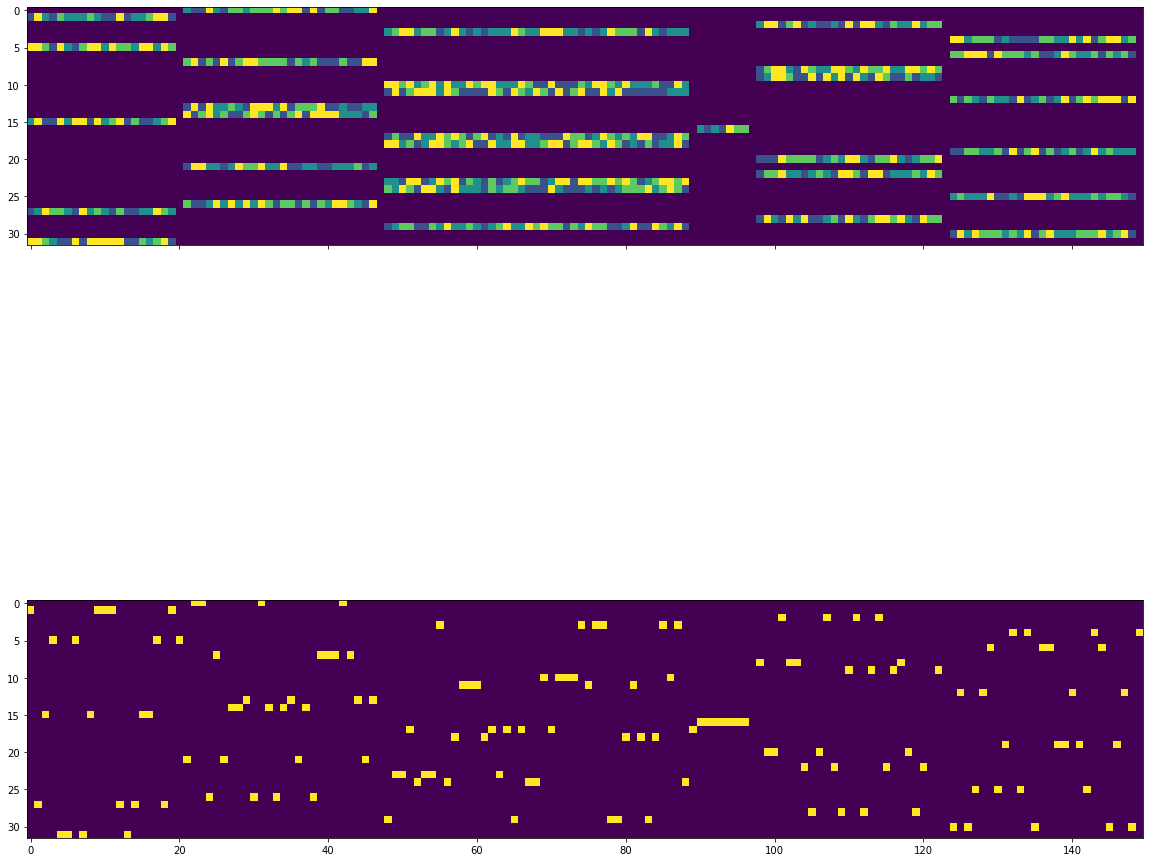

In [70]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,20))
ax1.imshow(cib[:,:32].T,interpolation='nearest')
ax2.imshow(assignments[:,:32].T,interpolation='nearest')
plt.savefig("Random block costs weekly schedule",dpi=500)

In [71]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

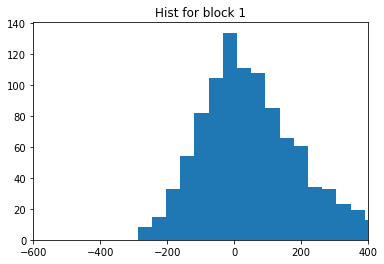

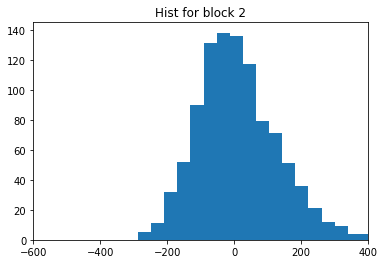

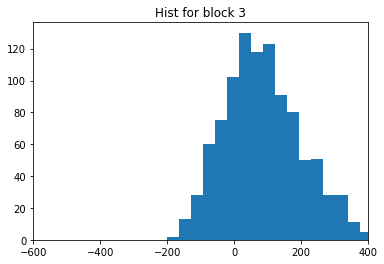

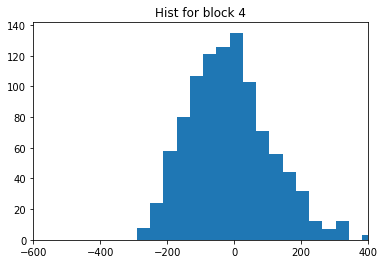

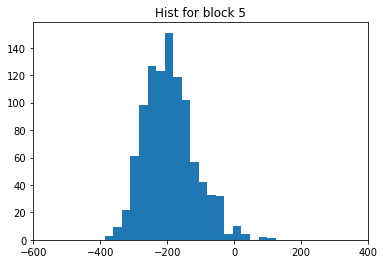

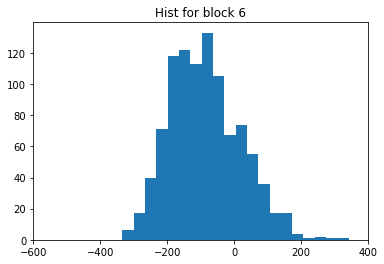

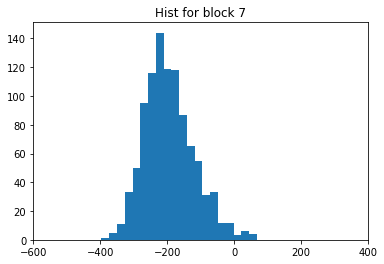

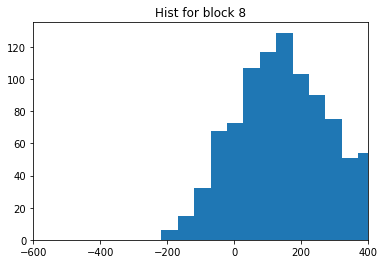

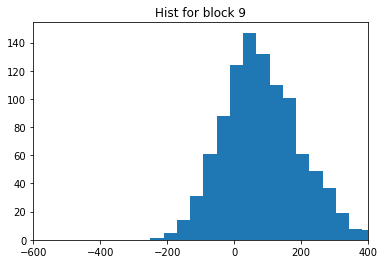

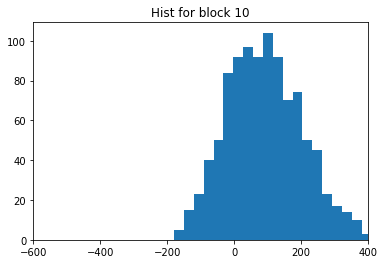

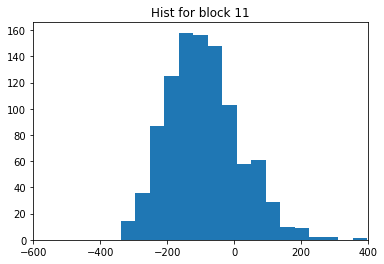

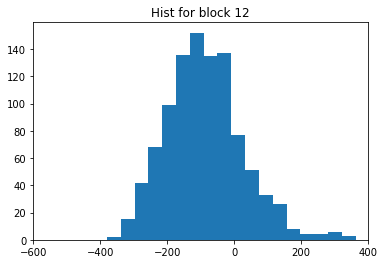

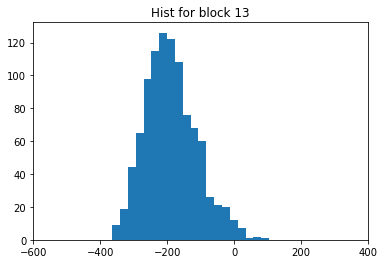

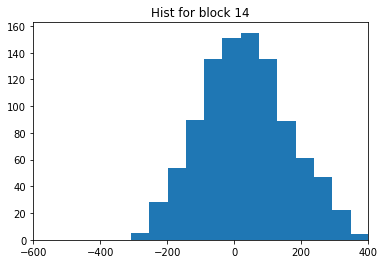

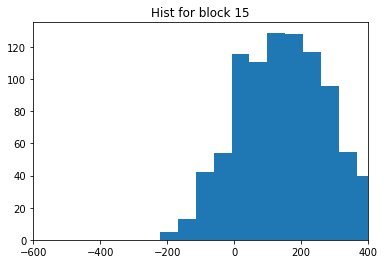

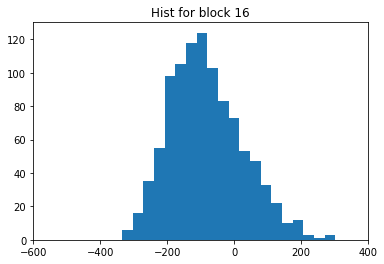

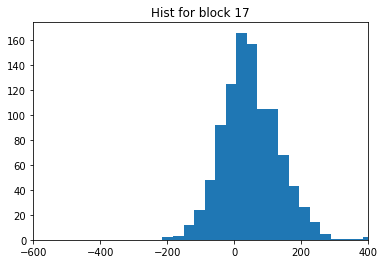

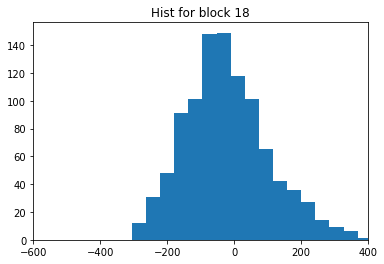

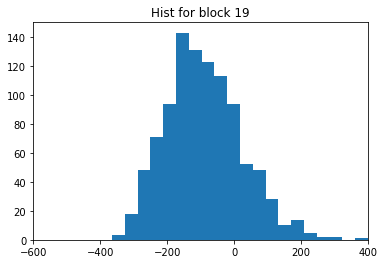

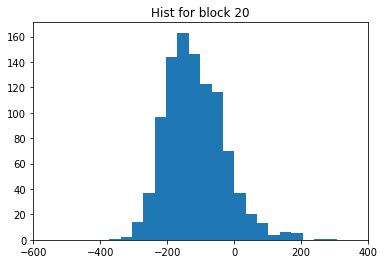

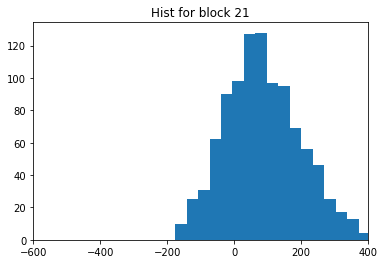

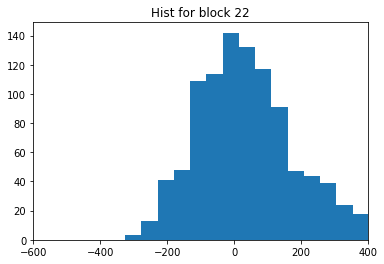

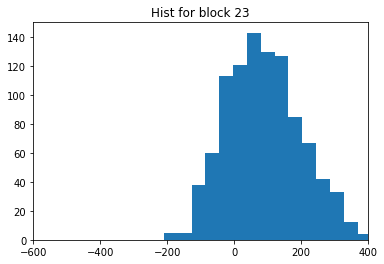

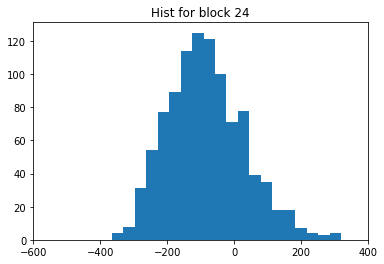

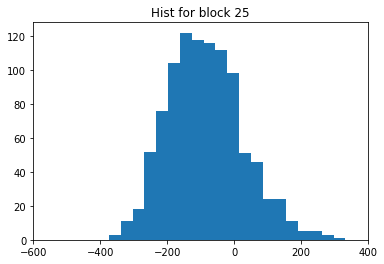

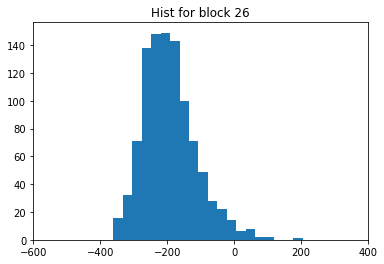

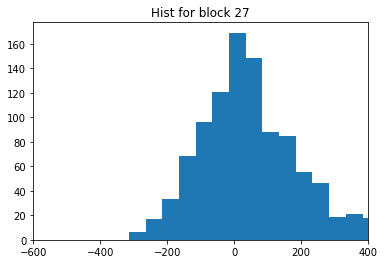

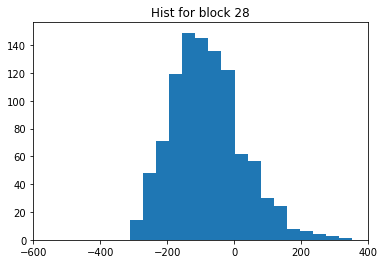

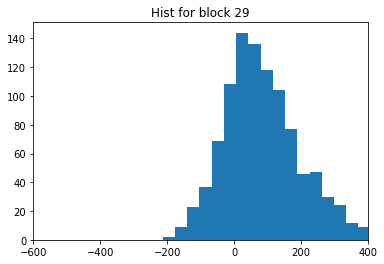

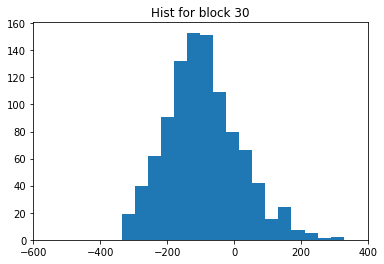

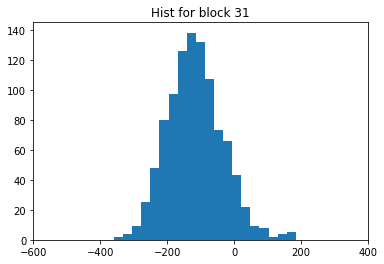

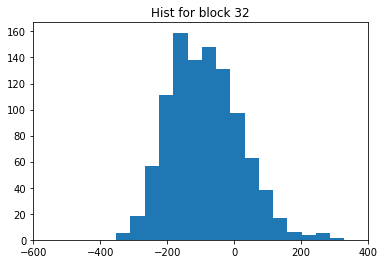

In [72]:
overtime = os-gs

for b in range(n_blocks-len(specs)):
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(-600,400)
    plt.show()

In [73]:
cib

array([[  0., 110.,   0., ...,   0.,   0.,   0.],
       [  0., 440.,   0., ...,   0.,   0.,   0.],
       [  0., 220.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 800.],
       [  0.,   0.,   0., ...,   0.,   0., 800.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [74]:
cib.shape

(150, 38)

In [75]:
cib[:2,:32]

array([[  0., 110.,   0.,   0.,   0., 440.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 220.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 110.,   0.,   0.,   0., 440.],
       [  0., 440.,   0.,   0.,   0., 440.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 440.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 220.,   0.,   0.,   0., 440.]])